#Classifying Customer Churn and Discovering It's Reasons
---






Our Main Tasks Are


1.   Classification of churn
2.   Find out top factors driving likelihood of churn
3.   Whether poor social status(low income, few cars, etc.) affects churn
4.   What can we do to reduce churn rate?



In [2]:
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
#loading our data
df = pd.read_csv('customer_churn.csv')

Getting acquainted with the data

In [6]:
df.shape

(100000, 100)

In [7]:
df.columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'churn', 'months',
       'uniqsubs', 'actvsubs', 'new_cell', 'crclscod', 'asl_flag', 'totcalls',
       'totmou', 'totrev', 'adjrev'

In [8]:
np.unique(df.dtypes,return_counts=True)

(array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object),
 array([10, 69, 21]))

In [9]:
len(df.isna())

100000

In [10]:
# get a brief look of our data
g = df.columns.to_series().groupby(df.dtypes).groups
print(g)

{dtype('int64'): Index(['churn', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'adjqty',
       'avg3mou', 'avg3qty', 'avg3rev', 'Customer_ID'],
      dtype='object'), dtype('float64'): Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
     

In [11]:
print('columns containing NaN: ', len(df.columns[df.isna().any()]))
print('rows containing NaN: ', len(df[df.isnull().any(axis=1)]))

columns containing NaN:  43
rows containing NaN:  73295


In [12]:
#get the categorical columns
categorical_columns = df.columns[df.dtypes=='O']
df[categorical_columns].head()

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,ownrent,dwlltype,marital,infobase,HHstatin,dwllsize,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,WCMB,O,S,S,M,C,A,N,U,U,U,U,U,Y
1,N,EA,N,U,CHICAGO AREA,N,N,WC,NaN,S,S,M,C,A,Z,U,U,U,U,U,Y
2,Y,C,N,S,GREAT LAKES AREA,N,N,NaN,O,S,M,M,C,A,N,U,Y,U,U,U,Y
3,Y,B,N,T,CHICAGO AREA,N,N,NaN,NaN,M,M,M,C,D,U,Y,U,U,U,U,Y
4,Y,A,N,U,NEW ENGLAND AREA,Y,N,WCMB,R,M,S,M,C,O,I,U,U,U,U,U,Y


In [13]:
categorical_columns

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [14]:
# get the numerical columns
numerical_columns = df.columns[df.dtypes!='O']
df[df.columns[df.dtypes!='O']].head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,lor,adults,income,numbcars,forgntvl,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,149.98999,2.0,2.0,0.0,0.0,15.0,1.0,4.0,3.0,0.0,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,NaN,7.0,6.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,29.98999,2.0,1.0,0.0,0.0,7.0,2.0,5.0,2.0,0.0,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,29.98999,1.0,1.0,0.0,0.0,6.0,4.0,6.0,1.0,0.0,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,149.98999,6.0,4.0,0.0,0.0,5.0,1.0,6.0,1.0,0.0,434.0,1000005


After inspecting the data I found the column of our labels




In [15]:
np.unique(df.churn)

array([0, 1])

In [16]:
# we want to find where our label 'sits at'
index_of_churn = df.columns.tolist().index('churn')
index_of_churn

48

In [17]:
# move our label column to the end of the dataframe for convenience
a = list(df.columns)
a.pop(index_of_churn)
a.append('churn')
df2 = df[a]

In [18]:
df2.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,...,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,churn
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,...,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001,1
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,...,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,...,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003,1
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,...,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,...,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005,0


## Data Manipulation

In [19]:
np.unique(df.churn,return_counts=True)

(array([0, 1]), array([50438, 49562]))

In [20]:
# so we have pretty evenly distributed classes in terms of their quantity

In [21]:
# Columns that contain more than 20% NaN
nan_columns = df.columns[df.isnull().mean() > 0.2]
print(nan_columns)

Index(['ownrent', 'lor', 'dwlltype', 'adults', 'infobase', 'income',
       'numbcars', 'HHstatin', 'dwllsize'],
      dtype='object')


In [22]:
# Missing values percentage in our data
def nan_percentage(dataframe):
  return dataframe .isnull().mean().mean()*100
nan_percentage(df)

3.4296899999999986

In [23]:
# The line of code written below gave me unique values of each categorical column(I mannually checked for every column and I extracted the ones that contain too many unique values)



```
print(np.unique(df[categorical_column], return_counts=True))

```



Further inspecting

In [24]:
df2 = df2.drop(['lor','dwlltype','infobase','HHstatin','dwllsize','crclscod','ethnic','area','Customer_ID','marital','change_mou','hnd_webcap','ownrent'],axis=1)

In [25]:
# Remaining columns have names that tell they might be important, so I won't remove them
df2.columns[df2.isnull().mean() > 0.2]

Index(['adults', 'income', 'numbcars'], dtype='object')

In [26]:
df2.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,...,months,uniqsubs,actvsubs,new_cell,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,dualband,refurb_new,hnd_price,phones,models,truck,rv,adults,income,numbcars,forgntvl,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,churn
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,...,61,2,1,U,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,Y,N,149.98999,2.0,2.0,0.0,0.0,1.0,4.0,3.0,0.0,U,U,U,U,U,Y,361.0,1
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,...,56,1,1,N,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,N,N,NaN,7.0,6.0,1.0,1.0,1.0,5.0,1.0,0.0,U,U,U,U,U,Y,240.0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,...,58,1,1,Y,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,N,N,29.98999,2.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,U,Y,U,U,U,Y,1504.0,1
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,...,60,1,1,Y,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,N,N,29.98999,1.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,Y,U,U,U,U,Y,1812.0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,...,57,1,1,Y,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,Y,N,149.98999,6.0,4.0,0.0,0.0,1.0,6.0,1.0,0.0,U,U,U,U,U,Y,434.0,0


In [27]:
print(df2.columns)

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_rev',
       'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean',
       'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean',
       'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean',
       'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean',
       'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean',
       'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean',
       'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean',
       'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean',
       'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean',
       'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs',
       'new_cell', 'asl_flag', 'totcalls', 'totmou', 'totrev', 'adjrev',
       'adjmou', 'adjqty', 'avgrev', 'av

In [28]:
# Lets mannually select the columns that can represent customer's social status(we'll need it later)
customers_social_status = ['income', 'numbcars','phones', 'truck', 'rv']

In [29]:
nan_percentage(df2)

1.5433333333333334

In [30]:
# we are missing ~ 1.54% of our data after removeing insignificant columns as apposed to ~ 3.34% before removeing columns

In [31]:
categorical_columns2 = df2.columns[df2.dtypes=='O']
df2[categorical_columns2].head()

,new_cell,asl_flag,prizm_social_one,dualband,refurb_new,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,N,S,Y,N,U,U,U,U,U,Y
1,N,N,U,N,N,U,U,U,U,U,Y
2,Y,N,S,N,N,U,Y,U,U,U,Y
3,Y,N,T,N,N,Y,U,U,U,U,Y
4,Y,N,U,Y,N,U,U,U,U,U,Y


In [32]:
numerical_columns2 = df2.columns[df2.dtypes!='O']
df2[numerical_columns2].head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,adults,income,numbcars,forgntvl,eqpdays,churn
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,61,2,1,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,149.98999,2.0,2.0,0.0,0.0,1.0,4.0,3.0,0.0,361.0,1
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,56,1,1,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,NaN,7.0,6.0,1.0,1.0,1.0,5.0,1.0,0.0,240.0,0
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,58,1,1,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,29.98999,2.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,1504.0,1
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,60,1,1,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,29.98999,1.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,1812.0,0
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,57,1,1,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,149.98999,6.0,4.0,0.0,0.0,1.0,6.0,1.0,0.0,434.0,0


In [33]:
x = []
y = []
for i in categorical_columns2:
  x.append(i)
  y.append(df2[i].isna().sum()/100000*100)


No handles with labels found to put in legend.


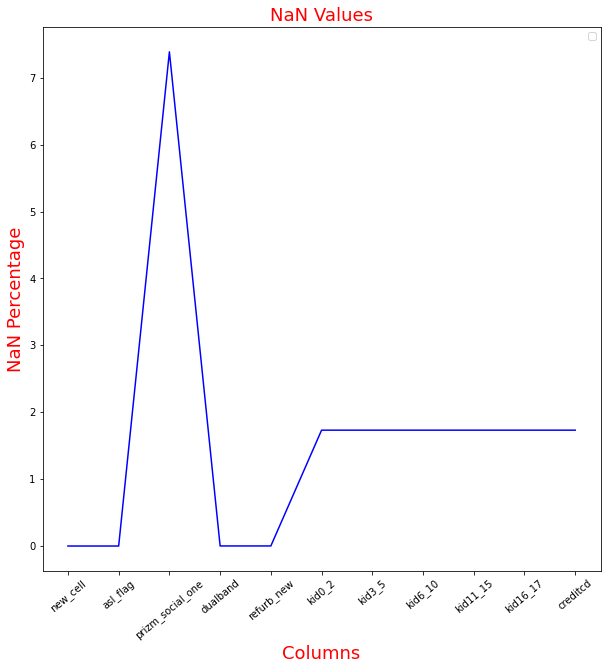

In [34]:
plt.figure(figsize=(10,10))
plt.plot(x,y,'-b')
plt.title('NaN Values',color='red',fontsize=18)
plt.ylabel('NaN Percentage',color='red',fontsize=18)
plt.xlabel('Columns',color='red',fontsize=18)
plt.xticks(rotation=40)
plt.legend();

In [35]:
# lets see if we have abnormal values in our categorical columns
categorical_cols = df2.columns[df2.dtypes=='O']
for categorical_col in categorical_cols:
  for i in df2[categorical_col].fillna('0'):
    if type(i) != str:
      print('abnormal_value','column: ', categorical_col,'index: ', i)

Lets' replace our missing values


In [36]:
print('categorical missing value percentage: ', nan_percentage(df2[categorical_columns2]))
print('numerical missing value percentage: ', nan_percentage(df2[numerical_columns2]))

categorical missing value percentage:  1.6165454545454545
numerical missing value percentage:  1.5327368421052634


In [37]:
# we will replace missing values in categorical columns with their mode

In [38]:
df2[categorical_columns2].mode()

,new_cell,asl_flag,prizm_social_one,dualband,refurb_new,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,N,S,Y,N,U,U,U,U,U,Y


In [39]:
for i in categorical_columns2:
  df2[i] = df2[i].fillna(df2[i].mode()[0])

In [40]:
nan_percentage(df2[categorical_columns2])

0.0

In [41]:
# we will replace missing values in numerical columns with their mean

In [42]:
df2[numerical_columns2].mean()

rev_Mean        58.719985
mou_Mean       513.559937
totmrc_Mean     46.179136
da_Mean          0.888828
ovrmou_Mean     41.072247
                  ...    
income           5.783112
numbcars         1.567563
forgntvl         0.057974
eqpdays        391.932309
churn            0.495620
Length: 76, dtype: float64

In [43]:
for i in numerical_columns2:
  df2[i] = df2[i].fillna(df2[i].mean())

In [44]:
nan_percentage(df2[numerical_columns2])

0.0

In [45]:
# So, we have filled all missing values in our dataset

In [46]:
if(nan_percentage(df2)==0):
  print('No Missing Value Left')

No Missing Value Left


In [47]:
for i in categorical_columns2:
  print('column name: ',i ,np.unique(df2[i],return_counts=True))

column name:  new_cell (array(['N', 'U', 'Y'], dtype=object), array([13785, 66914, 19301]))
column name:  asl_flag (array(['N', 'Y'], dtype=object), array([86064, 13936]))
column name:  prizm_social_one (array(['C', 'R', 'S', 'T', 'U'], dtype=object), array([17018,  4895, 39485, 14989, 23613]))
column name:  dualband (array(['N', 'T', 'U', 'Y'], dtype=object), array([23196,  4316,   222, 72266]))
column name:  refurb_new (array(['N', 'R'], dtype=object), array([85594, 14406]))
column name:  kid0_2 (array(['U', 'Y'], dtype=object), array([95988,  4012]))
column name:  kid3_5 (array(['U', 'Y'], dtype=object), array([95304,  4696]))
column name:  kid6_10 (array(['U', 'Y'], dtype=object), array([91927,  8073]))
column name:  kid11_15 (array(['U', 'Y'], dtype=object), array([91186,  8814]))
column name:  kid16_17 (array(['U', 'Y'], dtype=object), array([90036,  9964]))
column name:  creditcd (array(['N', 'Y'], dtype=object), array([31034, 68966]))


In [48]:
x_data = df2.iloc[:,:-1]
y_data = df2.iloc[:,-1]
print('df2: ', df2.shape)
print('x_data: ', x_data.shape)
print('y_data: ',y_data.shape)

df2:  (100000, 87)
x_data:  (100000, 86)
y_data:  (100000,)


In [49]:
# converting categorical variables into dummy variables
x_data = pd.get_dummies(x_data,categorical_columns2)

In [50]:
x_data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,...,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,adults,income,numbcars,forgntvl,eqpdays,new_cell_N,new_cell_U,new_cell_Y,asl_flag_N,asl_flag_Y,prizm_social_one_C,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,dualband_N,dualband_T,dualband_U,dualband_Y,refurb_new_N,refurb_new_R,kid0_2_U,kid0_2_Y,kid3_5_U,kid3_5_Y,kid6_10_U,kid6_10_Y,kid11_15_U,kid11_15_Y,kid16_17_U,kid16_17_Y,creditcd_N,creditcd_Y
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,...,136.0,38.0,149.989990,2.0,2.0,0.0,0.0,1.0,4.0,3.0,0.0,361.0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,...,275.0,48.0,101.875763,7.0,6.0,1.0,1.0,1.0,5.0,1.0,0.0,240.0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,...,6.0,17.0,29.989990,2.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,1504.0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,...,25.0,40.0,29.989990,1.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,1812.0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,...,196.0,80.0,149.989990,6.0,4.0,0.0,0.0,1.0,6.0,1.0,0.0,434.0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1


In [51]:
# Data normalization
x_data = (x_data - x_data.mean())/x_data.std()

In [52]:
# Splitting the x_data, y_data to train and test parts
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.2,
                                                    random_state=0)

Getting the most important features


In [53]:
# I'll use only the training data for feature selection to avoid data leakage
selector = SelectKBest(f_classif,k=10)
x_new = selector.fit_transform(x_train,y_train)

In [54]:
x_new

array([[-0.70781915, -0.68652479, -0.59784523, ...,  0.22640161,
         0.4023983 , -0.4023983 ],
       [ 1.38095921,  0.63878477,  2.80913513, ..., -1.41504609,
        -2.48507513,  2.48507513],
       [ 1.2569678 ,  1.22219237,  1.95176796, ...,  0.1796145 ,
         0.4023983 , -0.4023983 ],
       ...,
       [-0.89094492, -0.05042709, -0.85646091, ...,  0.51102318,
         0.4023983 , -0.4023983 ],
       [ 0.18682656, -0.26245966,  0.55187009, ..., -1.24739229,
        -2.48507513,  2.48507513],
       [-0.80224337, -0.48763824, -0.79461803, ..., -0.23757054,
         0.4023983 , -0.4023983 ]])

In [55]:
selected_features = pd.DataFrame(selector.inverse_transform(x_new), 
                                 index=x_train.index, 
                                 columns=x_train.columns)
selected_features.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,...,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,adults,income,numbcars,forgntvl,eqpdays,new_cell_N,new_cell_U,new_cell_Y,asl_flag_N,asl_flag_Y,prizm_social_one_C,prizm_social_one_R,prizm_social_one_S,prizm_social_one_T,prizm_social_one_U,dualband_N,dualband_T,dualband_U,dualband_Y,refurb_new_N,refurb_new_R,kid0_2_U,kid0_2_Y,kid3_5_U,kid3_5_Y,kid6_10_U,kid6_10_Y,kid11_15_U,kid11_15_Y,kid16_17_U,kid16_17_Y,creditcd_N,creditcd_Y
10382,0.0,-0.707819,-0.686525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597845,0.0,0.0,0.0,0.0,0.0,0.0,-0.572723,0.0,0.0,0.0,0.0,0.0,0.0,-0.538298,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.018750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226402,0.0,0.0,0.0,0.402398,-0.402398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73171,0.0,1.380959,0.638785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.809135,0.0,0.0,0.0,0.0,0.0,0.0,1.259146,0.0,0.0,0.0,0.0,0.0,0.0,2.569740,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.438224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.415046,0.0,0.0,0.0,-2.485075,2.485075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30938,0.0,1.256968,1.222192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.951768,0.0,0.0,0.0,0.0,0.0,0.0,0.910286,0.0,0.0,0.0,0.0,0.0,0.0,2.653828,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.183368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179615,0.0,0.0,0.0,0.402398,-0.402398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99310,0.0,-0.829585,-0.686525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.803051,0.0,0.0,0.0,0.0,0.0,0.0,-0.800632,0.0,0.0,0.0,0.0,0.0,0.0,-0.476849,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.183368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.856153,0.0,0.0,0.0,0.402398,-0.402398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58959,0.0,-0.876638,-0.686525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.814295,0.0,0.0,0.0,0.0,0.0,0.0,-0.705802,0.0,0.0,0.0,0.0,0.0,0.0,-0.780861,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.689515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.260964,0.0,0.0,0.0,0.402398,-0.402398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
selected_cols = selected_features.columns[selected_features.var() != 0]

In [57]:
selected_cols

Index(['mou_Mean', 'totmrc_Mean', 'comp_vce_Mean', 'mou_cvce_Mean',
       'peak_vce_Mean', 'complete_Mean', 'hnd_price', 'eqpdays', 'asl_flag_N',
       'asl_flag_Y'],
      dtype='object')

In [58]:
if set(selected_cols) & set(customers_social_status):
  print(set(selected_cols) & set(customers_social_status))
else:
  print('No Common Features')

No Common Features


In [59]:
# At first glance customer's social status does not affect churn rate all that much
# Let's dig in a litte bit further 

Now let's display a plot which shows common features of `selected_columns` with `customers_social_status` depending on the number of `selected_columns`

In [60]:
k_values = range(10,40,2)
selected_columns_numbers = []
common_features_numbers = []
common_features_dict = {}

for k_value in k_values:
  selector = SelectKBest(f_classif, k=k_value)
  x_new = selector.fit_transform(x_train,y_train)
  selected_features = pd.DataFrame(selector.inverse_transform(x_new), 
                                 index=x_train.index, 
                                 columns=x_train.columns)
  selected_columns = selected_features.columns[selected_features.var() != 0]
  b = set(selected_columns) & set(customers_social_status)
  selected_columns_numbers.append(k_value)
  common_features_numbers.append(len(b))
  common_features_dict.update({k_value :b})


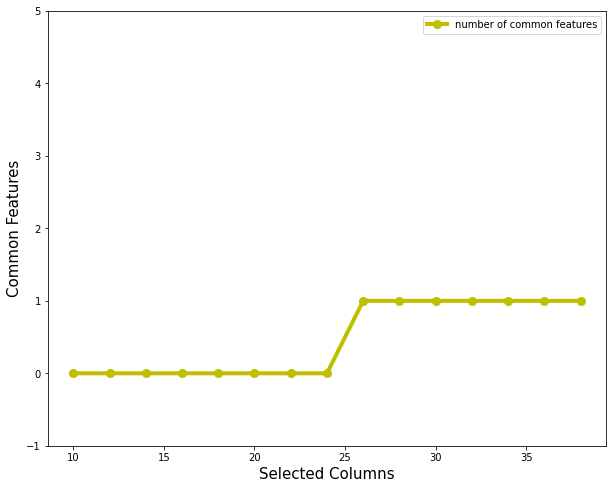

In [61]:
plt.figure(figsize=(10,8))
plt.ylim(-1,len(customers_social_status))
plt.xlabel('Selected Columns',fontsize=15)
plt.ylabel('Common Features',fontsize=15)

plt.plot(selected_columns_numbers,common_features_numbers,
         '-oy',
         linewidth=4,
         markersize=8,
         label='number of common features')

plt.legend();

In [62]:
common_features_dict

{10: set(),
 12: set(),
 14: set(),
 16: set(),
 18: set(),
 20: set(),
 22: set(),
 24: set(),
 26: {'phones'},
 28: {'phones'},
 30: {'phones'},
 32: {'phones'},
 34: {'phones'},
 36: {'phones'},
 38: {'phones'}}

In [63]:
# So we can see that social status doesen't affect churn and the most important feature of social status is just 26th most important overall
# From here We can answer to number 2 and 3 tasks

Answering Task 'number 2' (Find out top factors driving likelihood of churn)

In [64]:
print('Top 5 Factors Influenceing Churn are: ')
for i in range(5):
  print(i+1 , ': ', selected_cols[i])


Top 5 Factors Influenceing Churn are: 
1 :  mou_Mean
2 :  totmrc_Mean
3 :  comp_vce_Mean
4 :  mou_cvce_Mean
5 :  peak_vce_Mean


Answering Task 'number 3' (Whether poor social status affects churn)

In [65]:
# Answer: No, social status is a minor factor

##Classification

Let's See What We Have Done to Our Data So Far

In [3]:
# loading data
df = pd.read_csv('customer_churn.csv')
# pushinh label column to the end of the dataset
a = list(df.columns)
index_of_churn = df.columns.tolist().index('churn')
a.pop(index_of_churn)
a.append('churn')
df2 = df[a]
# removeing unnecessary columns
df2 = df2.drop(['lor','dwlltype','infobase','HHstatin','dwllsize','crclscod','ethnic','area','Customer_ID','marital','change_mou','hnd_webcap','ownrent'],axis=1)


categorical_columns2 = df2.columns[df2.dtypes=='O']
numerical_columns2 = df2.columns[df2.dtypes!='O']


# replaceing nan
for i in categorical_columns2:
  df2[i] = df2[i].fillna(df2[i].mode()[0])
for i in numerical_columns2:
  df2[i] = df2[i].fillna(df2[i].mean())

# splitting data
x_data = df2.iloc[:,:-1]
y_data = df2.iloc[:,-1]

#x_data = pd.concat([x_data[selected_columns2],x_data[categorical_columns2]],axis=1)



# data encodeing
x_data = pd.get_dummies(x_data,categorical_columns2)

#data normalization
x_data = (x_data - x_data.mean())/x_data.std()

In [97]:
x_data.shape

(100000, 103)

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.25,
                                                    random_state=0)
model1 = LogisticRegression()
model1.fit(x_train,y_train)

model2 = RandomForestClassifier()
model2.fit(x_train,y_train)

model3 = DecisionTreeClassifier()
model3.fit(x_train,y_train)

print('Logistic Regression: ',accuracy_score(model1.predict(x_test),y_test))
print('Random Forest: ', accuracy_score(model2.predict(x_test),y_test))
print('Decition Tree: ', accuracy_score(model3.predict(x_test),y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression:  0.57252
Random Forest:  0.59236
Decition Tree:  0.53688


In [ ]:
# Random Forest algorithm is the best performer with default parameters, so, we'll choose it as our classifying algorithm

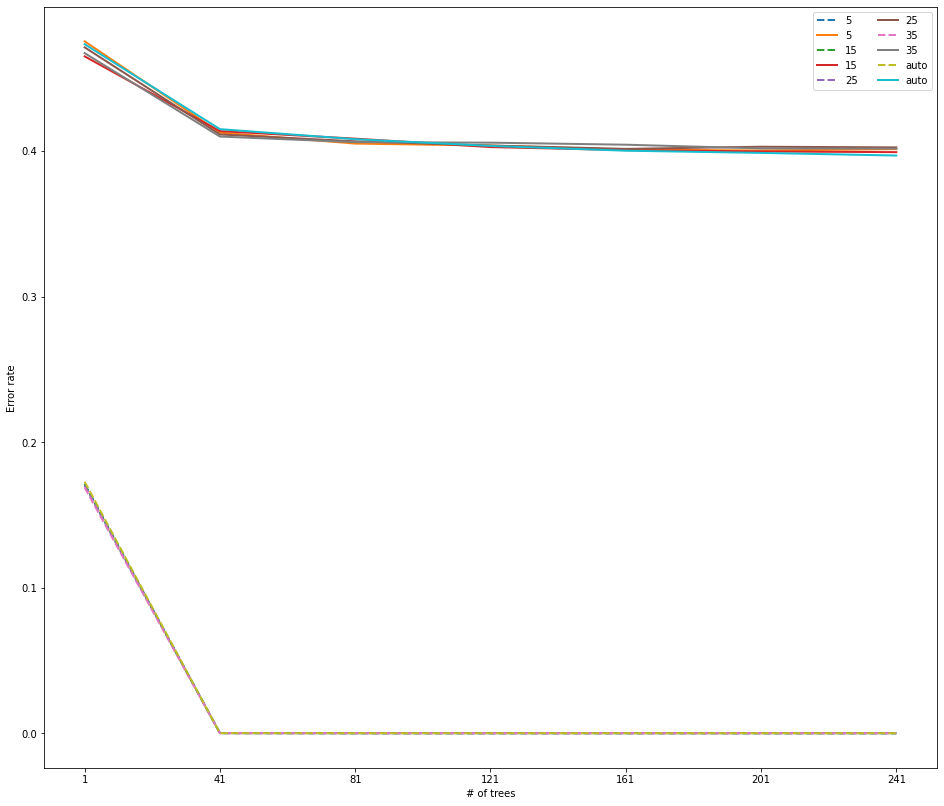

In [75]:
plt.figure(figsize=(16,14))
ensemble_sizes = range(1, 281, 40)
for nr_features in [5, 15, 25, 35, 'auto']:
    
    error_rates = {'train':[], 'test':[]}

    for i in ensemble_sizes:
        model = RandomForestClassifier(n_estimators = i,
                                       random_state = 0,
                                       max_features=nr_features)

        model.fit(x_train, y_train)

        error_rates['train'].append(
            1 - accuracy_score(model.predict(x_train), y_train)
            )
        error_rates['test'].append(
            1 - accuracy_score(model.predict(x_test), y_test)
            )
    plt.plot(ensemble_sizes, error_rates['train'],
             label=f'{nr_features}', linestyle='--', linewidth=2)
    plt.plot(ensemble_sizes, error_rates['test'],
             label=f'{nr_features}', linewidth=2)
plt.xlabel('# of trees')
plt.ylabel('Error rate')
plt.xticks(ensemble_sizes)
plt.legend(ncol=2)
plt.show()

In [ ]:
# So, we have a huge overfit,lets eliminate some non-important numerical columns

In [84]:
# loading data
df = pd.read_csv('customer_churn.csv')
# pushinh label column to the end of the dataset
a = list(df.columns)
index_of_churn = df.columns.tolist().index('churn')
a.pop(index_of_churn)
a.append('churn')
df2 = df[a]
# removeing unnecessary columns
df2 = df2.drop(['lor','dwlltype','infobase','HHstatin','dwllsize','crclscod','ethnic','area','Customer_ID','marital','change_mou','hnd_webcap','ownrent'],axis=1)


categorical_columns2 = df2.columns[df2.dtypes=='O']
numerical_columns2 = df2.columns[df2.dtypes!='O']


# replaceing nan
for i in categorical_columns2:
  df2[i] = df2[i].fillna(df2[i].mode()[0])
for i in numerical_columns2:
  df2[i] = df2[i].fillna(df2[i].mean())

# splitting data
x_data = df2.iloc[:,:-1]
y_data = df2.iloc[:,-1]

# selecting top 15 numerical columns
selector2 = SelectKBest(f_classif, k=15)
numerical_columns3 = numerical_columns2[:-1]
x_train2 = x_train[numerical_columns3]
x_new2 = selector2.fit_transform(x_train2,y_train)
selected_features2 = pd.DataFrame(selector2.inverse_transform(x_new2), 
                                 index=x_train2.index, 
                                 columns=x_train2.columns)
selected_columns2 = selected_features2.columns[selected_features2.var() != 0]


x_data = pd.concat([x_data[selected_columns2],x_data[categorical_columns2]],axis=1)

# data encodeing
x_data = pd.get_dummies(x_data,categorical_columns2)

#data normalization
x_data = (x_data - x_data.mean())/x_data.std()


In [4]:
# Splitting the x_data, y_data to train and test parts
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.2,
                                                    random_state=0)

In [5]:
x_train.shape

(80000, 103)

In [89]:
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [90]:
print('error on test: ', accuracy_score(model.predict(x_test),y_test))
print('error on train: ', accuracy_score(model.predict(x_train),y_train))

error on test:  0.58455
error on train:  1.0


In [91]:
# We have overfitting here too and the error on the test data is worse, so well stick with not removeing numerical columns

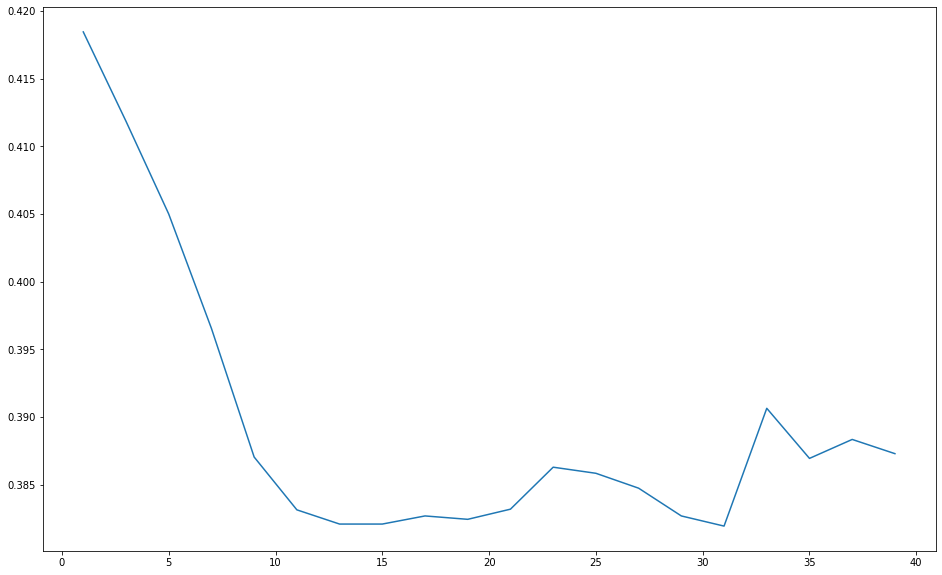

In [7]:
plt.figure(figsize=(16,10))
losses = []

depth_sizes = range(1, 41, 2)
for i in depth_sizes:
  model = RandomForestClassifier(max_depth = i, random_state = 0)
  model.fit(x_train,y_train)
  losses.append(1-accuracy_score(model.predict(x_test),y_test))

plt.plot(depth_sizes,losses)

In [8]:
print('The best depth size is: ' ,depth_sizes[losses.index(min(losses))])

The best depth size is:  31


In [10]:
parameters={
    'criterion' : ['entropy','gini'],
    'max_depth' : [12,13,14,30,31]}
model = RandomForestClassifier()
clf = GridSearchCV(model, parameters,
                   scoring='accuracy', cv=5)
clf.fit(x_data, y_data)
model = RandomForestClassifier()

In [11]:
clf.best_params_


{'criterion': 'entropy', 'max_depth': 14}

In [13]:
#Cross Validation Mean Score
model = RandomForestClassifier(n_estimators=281, criterion = 'entropy', max_features='auto' , max_depth = 14 )
scores = cross_val_score(model, x_data, y_data, cv=5, scoring = 'accuracy')
print(scores)
print(scores.mean())

[0.6056  0.58    0.55005 0.6068  0.5943 ]
0.58735


Final Model

In [12]:
# Fit all the data for the final model
model = RandomForestClassifier(n_estimators=281, criterion = 'entropy', max_features='auto' , max_depth = 14 )
model.fit(x_data,y_data)